In [1]:
import cv2
import yaml
import os
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch.nn import functional as F

import onnx
import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic

#### 모델 로딩
1. BISENet v1 로딩

In [2]:
CONVERSION_REGISTRY = {
    'v1_ade20k' : {'weight' : "./weights/model_final_v1_ade20k.pth", 'cfg' : "./configs/bisenetv1_ade20k.py"},
    'v1_city' : {'weight' : "./weights/model_final_v1_city_new.pth", 'cfg' : "./configs/bisenetv1_city.py"},
    'v1_coco' : {'weight' : "./weights/model_final_v1_coco_new.pth", 'cfg' : "./configs/bisenetv1_coco.py"},
    'v2_ade20k' : {'weight' : "./weights/model_final_v2_ade20k.pth", 'cfg' : "./configs/bisenetv2_ade20k.py"},
    'v2_city' : {'weight' : "./weights/model_final_v2_city.pth", 'cfg' : "./configs/bisenetv2_city.py"},
    'v2_coco' : {'weight' : "./weights/model_final_v2_coco.pth", 'cfg' : "./configs/bisenetv2_coco.py"},
}

In [3]:
from configs import set_cfg_from_file
from lib.models import model_factory

def model_conversion(model_path, config_path, dummy_inputs, onnx_model_path):

    cfg = set_cfg_from_file(config_path)
    
    # define model
    net = model_factory[cfg.model_type](cfg.n_cats, 'onnx')
    net.load_state_dict(torch.load(model_path), strict = False)
    net.cuda()
    net.eval()

    print('모델 로딩 완')

    # onnx conversion
    torch.onnx.export(
        model=net,                            # 실행될 모델
        args = tuple(dummy_inputs.values()),        # 모델 입력값(tuple or 여러 입력값)
        f = onnx_model_path,                     # 모델 저장 경로
        export_params=True,                 # 모델 파일 안에 학습된 모델 가중치 저장 여부
        opset_version=13,                   # 모델 변환할 때 사용할 onnx 버전
        do_constant_folding = True,         # 최적화시 상수폴딩 사용할지 여부
        input_names=list(dummy_inputs.keys()),
        output_names    =   ["output"],
        dynamic_axes    =   {
            'input'     : {0 : 'batch_size'},    # 가변적인 길이를 가진 차원
            'output'    : {0 : 'batch_size'}
        }
    ) 

In [4]:
# onnx 모델 저장 경로
os.makedirs('./onnx_models/', exist_ok=True)
device    = torch.device('cuda')
dummy_inputs = {
    "input" : torch.as_tensor(np.ones([1, 3, 512, 512]), dtype = torch.float32).to(device)
}

for modelN in CONVERSION_REGISTRY.keys():
    v1, ds = modelN.split('_')
    data = CONVERSION_REGISTRY[modelN]

    # model 변환
    onnx_model_path = f'./onnx_models/bisenet_{v1}_{ds}.onnx'
    onnx_model_quantized_path = f'./onnx_models/bisenet_{v1}_{ds}_quant.onnx'

    #model_conversion
    print(f'[{v1}] {ds} -> {onnx_model_path}')
    model_conversion(data['weight'], data['cfg'], dummy_inputs, onnx_model_path)

    # model quantization
    quantize_dynamic(
    model_input=onnx_model_path,
    model_output=onnx_model_quantized_path,
    #optimize_model=True,
    per_channel=False,
    reduce_range=False,
    weight_type=QuantType.QUInt8,
)

[v1] ade20k -> ./onnx_models/bisenet_v1_ade20k.onnx
모델 로딩 완


[v1] city -> ./onnx_models/bisenet_v1_city.onnx
모델 로딩 완


[v1] coco -> ./onnx_models/bisenet_v1_coco.onnx
모델 로딩 완


[v2] ade20k -> ./onnx_models/bisenet_v2_ade20k.onnx
모델 로딩 완


[v2] city -> ./onnx_models/bisenet_v2_city.onnx
모델 로딩 완


[v2] coco -> ./onnx_models/bisenet_v2_coco.onnx
모델 로딩 완


#### ONNX-Runtime Test

In [31]:
import lib.data.transform_cv2 as T
import math

# prepare data
to_tensor = T.ToTensor(
    mean=(0.3257, 0.3690, 0.3223), # city, rgb
    std=(0.2112, 0.2148, 0.2115),
)
im = cv2.imread('./moana.jpg')[:, :, ::-1]
im = to_tensor(dict(im=im, lb=None))['im'].unsqueeze(0).cuda()

# shape divisor
org_size = im.size()[2:]
new_size = [512, 512]

im = F.interpolate(im, size=new_size, align_corners=False, mode='bilinear')
image_embedding = im.detach().cpu().numpy()
image_embedding.shape


(1, 3, 512, 512)

(512, 512, 3)


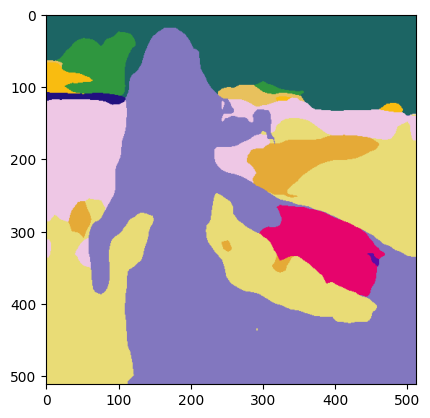

In [35]:
# loading
ort_session = onnxruntime.InferenceSession('./onnx_models/bisenet_v1_coco.onnx', providers=['AzureExecutionProvider'])

# test running
ort_inputs  = {ort_session.get_inputs()[0].name : image_embedding}
ort_outputs = ort_session.run(None, ort_inputs)

# show & save result
print(ort_outputs[0].shape)
plt.imshow(ort_outputs[0])
plt.savefig('./result.png')